In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
from ipywidgets import interact
from scipy.interpolate import Rbf
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from scipy.interpolate import LinearNDInterpolator

plt.rcParams['figure.figsize'] = [10, 10]

#source brightness distribution profiles
def rad(x,y,s,f):
    return 1.5*s/(np.sqrt(x**2+y**2)+0.1)

def radsqr(x,y,s,f):
    return 2*s/(x**2+y**2+0.1)

def exp(x,y,s,f):
    return 15*np.exp(-(3*s*np.sqrt(x**2+y**2))+0.1)

def twopoints(x,y,s,f):
    return 1.5/(np.sqrt((x-s)**2+(y)**2))+1.5/(np.sqrt((x+s)**2+(y)**2)+0.01)

def multipoint(x,y,nn,centt_x,centt_y,peak):
    
    bri = np.zeros(nn)
    
    for i in range(nn):
        bri[i] = peak[i]/((x-centt_x[i])**2+(y-centt_y[i])**2+0.01)
    
    bb = np.sum(bri)
                       
    return bb

def point(x,y,s,f):
    if x**2 + y**2 < 0.1*s:
        return 10
    else:
        return 0

#xi_1 will be x
#xi_2 will be y
    
def ellipse(x,y,s,f,angle):
    xnew = x*np.cos(angle)-y*np.sin(angle)
    ynew = x*np.sin(angle)+y*np.cos(angle)
    return np.sqrt(f)*3*s*(1/np.sqrt(xnew**2+(f**2)*ynew**2)) 
    
#alphas

def alpha_point(x,y,f):
    theta = np.sqrt(x**2+y**2)
    phi = math.atan2(y,x)
    r = 1/theta
    xx = r*np.cos(phi)
    yy = r*np.sin(phi)
    return (xx,yy)    

def alpha_SIS(x,y,f):
    theta = np.sqrt(x**2+y**2)
    phi = math.atan2(y,x)
    r = theta/np.abs(theta)
    xx = r*np.cos(phi)
    yy = r*np.sin(phi)
    return (xx,yy) 

def alpha_SIE(x,y,f):
    if x == y == 0:
        phi = 0
    else:
        phi = math.atan2(y,x)
        
    xx = np.sqrt(f/(1-f**2))*np.arcsinh(np.sqrt(1-f**2)*np.cos(phi)/f)   
    yy = np.sqrt(f/(1-f**2))*np.arcsin(np.sqrt(1-f**2)*np.sin(phi))
    
    return (xx,yy) 


def delta(phi,ff):
    return np.sqrt((np.cos(phi))**2+(ff**2)*(np.sin(phi))**2)

#the random positions of all the points in multipoint
cent_x = np.random.uniform(low=-4.0, high=4.0, size=100)
cent_y = np.random.uniform(low=-2.0, high=2.0, size=100)
peaks = np.random.uniform(low=0.0, high=0.1, size=100)


#x and y coordinates for plotting the Einstein radius
xcircle = np.linspace(-1,1,100)
ycircle = np.sqrt(1-xcircle**2)
ycircle2 = -np.sqrt(1-xcircle**2)


#plotting an interactive graph
def graph(fineness=100, profile='rad',lens='point mass',lens_visibility='opaque',s_parameter=2,f_lens=0.5,f_source=0.5,angle_source=0,centre_x=0.0,centre_y=0.0):
    
    f = f_lens
    
    if profile == 'rad':
        prof = rad
    elif profile == 'radsqr':
        prof = radsqr
    elif profile == 'exp':
        prof = exp
    elif profile =='two points':
        prof = twopoints
    elif profile=='multiple points':
        prof = multipoint
    elif profile=='point':
        prof = point
    elif profile=='ellipse':
        prof = ellipse
        
    if lens == 'point mass':
        alpha = alpha_point
        lens_profile = point
        
    elif lens == 'SIS':
        alpha = alpha_SIS
        lens_profile = radsqr
        
    elif lens == 'SIE':
        alpha = alpha_SIE
        lens_profile = ellipse
    
    #max X and Y values out to which we plot the brightness distribution 
    maxx = 3
    
    #the x and y coordinates of all points in the source
    x = np.linspace(-maxx,maxx,fineness)
    y = np.linspace(-maxx,maxx,fineness)
    
    #we need to turn this into a grid, and so
    X,Y  = np.meshgrid(x,y)
    
    #creating an array to hold the values of brightness
    source_brightnesses = np.zeros(X.shape)
    source_brightnesses = np.zeros(X.shape)
    image_brightnesses = np.zeros(X.shape)
    lensb = np.zeros(X.shape)
    
    #calculating the brightnesses for the choice of profile
    if profile == 'multiple points':
    
        n = int(round(20*s_parameter))

        for i in range(len(x)):
            for j in range(len(y)):
                xs = X[i][j]-centre_x
                ys = Y[i][j]-centre_y
                source_brightnesses[i][j] = prof(xs,ys,n,cent_x,cent_y,peaks)
                image_brightnesses[i][j] = prof(xs-alpha(X[i][j],Y[i][j],f)[0],ys-alpha(X[i][j],Y[i][j],f)[1],n,cent_x,cent_y,peaks)
    
    elif profile == 'ellipse':
        for i in range(len(x)):
            for j in range(len(y)):
                xs = X[i][j]-centre_x
                ys = Y[i][j]-centre_y
                source_brightnesses[i][j] = ellipse(xs,ys,0.5*s_parameter,f_source,angle_source)            
                image_brightnesses[i][j] = prof(xs-alpha(X[i][j],Y[i][j],f)[0],ys-alpha(X[i][j],Y[i][j],f)[1],0.5*s_parameter,f_source,angle_source)         
    
    else:
        for i in range(len(x)):
            for j in range(len(y)):
                xs = X[i][j]-centre_x
                ys = Y[i][j]-centre_y
                source_brightnesses[i][j] = prof(xs,ys,0.5*s_parameter,f)            
                image_brightnesses[i][j] = prof(xs-alpha(X[i][j],Y[i][j],f)[0],ys-alpha(X[i][j],Y[i][j],f)[1],0.5*s_parameter,f) 
    
    if lens=='SIE':
        for i in range(len(x)):
            for j in range(len(y)):
                lensb[i][j] = lens_profile(X[i][j],Y[i][j],0.5,f,0)        
    else:
        for i in range(len(x)):
            for j in range(len(y)):
                lensb[i][j] = lens_profile(X[i][j],Y[i][j],0.5,f)
    
    #calculating the critical curve
    if lens == 'SIE':
        phis = np.linspace(0,2*np.pi,1000)
        r = np.zeros(len(phis))
        crit_x = np.zeros(len(phis))
        crit_y = np.zeros(len(phis))      
        caust_x = np.zeros(len(phis))
        caust_y = np.zeros(len(phis))  
        for i in range(len(phis)):
            r[i] = np.sqrt(f)/np.sqrt((np.cos(phis[i]))**2+(f**2)*(np.sin(phis[i]))**2)
            crit_x[i] = r[i]*np.cos(phis[i])
            crit_y[i] = r[i]*np.sin(phis[i])
            caust_x[i] = crit_x[i] - alpha(crit_x[i],crit_y[i],f)[0]
            caust_y[i] = crit_y[i] - alpha(crit_x[i],crit_y[i],f)[1]
    

    #sets the colour gradients
    levlist = np.arange(0,11,0.2)
    lenslev1 = np.arange(8,18,1)
    lenslev2 = np.arange(3,18,1)
    
    plt.figure(1)
    gs = gridspec.GridSpec(2, 1,height_ratios=[1,1])

    ax1=plt.subplot(gs[0])
    plt.title('Source Plane')
    line1 = plt.contourf(X,Y,source_brightnesses,levels=levlist,cmap=plt.get_cmap('hot'))
    line2 = plt.plot(0,0,'bx')
    if lens == 'SIE':
        line4 = plt.plot(caust_x,caust_y,'g--')    
    elif lens == 'point mass' or 'SIS':
        line4 = plt.plot(xcircle,ycircle,'b--')
        line5 = plt.plot(xcircle,ycircle2,'b--')
    plt.xlim(-3,3)
    plt.ylim(-1.5,1.5)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    
    #X_edges, Y_edges = np.meshgrid(edges, edges)
    
    ax2=plt.subplot(gs[1])
    plt.title('Image Plane')
    line1 = plt.contourf(X,Y,image_brightnesses,levels=levlist, cmap=plt.get_cmap('hot'))
    line3 = plt.plot(0,0,'bx')
    if lens == 'SIE':
        line4 = plt.plot(crit_x,crit_y,'g--')    
    elif lens == 'point mass' or 'SIS':
        line4 = plt.plot(xcircle,ycircle,'b--')
        line5 = plt.plot(xcircle,ycircle2,'b--')
    plt.colorbar()
    if lens_visibility=='opaque':
        line6 = plt.contourf(X,Y,lensb,levels=lenslev1, cmap=plt.get_cmap('Blues_r'),alpha = 0.9,extend='max')  
        line7 = plt.contourf(X,Y,lensb,levels=lenslev2, cmap=plt.get_cmap('Blues_r'),alpha = 0.5,extend='max')
    plt.xlim(-3,3)
    plt.ylim(-1.5,1.5)
    plt.gca().set_aspect('equal')



interact(graph, fineness = [10,20,50,70,100,200,500,1000],profile=['rad','radsqr','exp','two points','multiple points','point','ellipse'],lens=['point mass','SIS','SIE'],lens_visibility=['opaque','transparent'], s_parameter = (0,5,0.2), f_lens=(0.1,0.99,0.05), f_source=(0.1,0.99,0.05), angle_source=(0.0,np.pi,0.05), centre_x=(-3,3,0.05),centre_y=(-3,3,0.05))
plt.show()

interactive(children=(Dropdown(description='fineness', index=4, options=(10, 20, 50, 70, 100, 200, 500, 1000),…

### Standard imports

In [3]:
# some standard python imports #
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

## LensModel

The LensModel package executes everything which is purely lensing related. Ray-shooting, solving the lens equation, arrival time computation and non-linear solers to optimize lens models for specific image configuration.

LensModel is a class. When setting up a lens model, we define an item of that class, which is classified according to a list of lens models.

The default setting for LensModel is single plane lensing. Any lens models entered into the list will be super-imposed on one another.

The lens models can be found at: https://lenstronomy.readthedocs.io/en/latest/lenstronomy.LensModel.Profiles.html

The base_profile class "acts as the base class of all lens model functions and indicates raise statements and default outputs if these functions are not defined in the specific lens model class"

There's also an explanation for flexion, F flexion and G flexion, the Hessian distortion, and the numerical deflections module, which allows any lens profile to be incorporated into lenstronomy, and calculated numerically

the rest of it just lists the module, presumably the inputs are the same as for the base_profile class

Note, for LensModel, you specify the type of lens model which you are working with, but must then further specify the keyword arguments when using attributes of LensModel.

*note, while a redshift for the lens or source is not specified, this kind of information is contained within the specification of the Einstein radius

In [4]:
#firstly, we stick all the lens models we're going to use in a list, as follows

lens_model_list = ['EPL', 'SHEAR']   

#the lens model class is then set up by entering in this list
lensModel = LensModel(lens_model_list=lens_model_list)

#each of the lens models needs key word arguments, which we define as separate lists
kwargs_epl = {'theta_E': 1.1, 'e1': 0.1, 'e2': 0.1, 'gamma': 2., 'center_x': 0.1, 'center_y': 0}
kwargs_shear = {'gamma1': -0.01, 'gamma2': .03}

#these lists then get combined into a master list of keywords, which is fed into the calculations
kwargs_lens = [kwargs_epl, kwargs_shear]

# these are the (angular) coordinates at which the image is observed
#presumably this would normally be a whole set of values
theta_ra, theta_dec = 1., .5

## and this uses the lens equation to trace this image back to the source which produced it
beta_ra, beta_dec = lensModel.ray_shooting(theta_ra, theta_dec, kwargs_lens)

## the Fermat potential is calculated using the image positions, source positions and lens properties. 
fermat_pot = lensModel.fermat_potential(x_image=theta_ra, y_image=theta_dec, x_source=beta_ra, y_source=beta_dec, kwargs_lens=kwargs_lens)

## the magnification, calculated at specific image coordinates
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)



### Multi-Plane Lensing

Instead of having all the lenses in a single plane, they can instead be separated out by specifying different redshifts

*now, we have to specify the redshift of all the planes, including the source

Notice that the lensModel class which is defined then has e.g. .ray_shooting or .magnification put at the end to get those values from the model. These things take right ascension and declinations as 

In [5]:
#the source redshift
z_source = 1.5

#the redshifts of the planes. Note that the external shear is given the same redshift as the primary lens 
redshift_list = [0.5, 0.5, .1]

#Once again, we put in a list of lens models, but this time, we feed the redshifts into the lensmodel function as well
#you also need to set multi_plane to be true
lens_model_list_mp = ['EPL', 'SHEAR', 'SIS']
lensModel_mp = LensModel(lens_model_list=lens_model_list_mp, z_source=z_source, lens_redshift_list=redshift_list, multi_plane=True)

#we use the same parameters for EPL and SHEAR, but now add SIS parameters
kwargs_sis = {'theta_E': 0.1, 'center_x': 1., 'center_y': -0.1}
kwargs_lens_mp = [kwargs_epl, kwargs_shear, kwargs_sis]

# source plane coordinate
beta_ra, beta_dec = lensModel_mp.ray_shooting(theta_ra, theta_dec, kwargs_lens_mp)

# Magnification
mag = lensModel_mp.magnification(theta_ra, theta_dec, kwargs_lens_mp)

# arrival time relative to a straight path through (0,0) 
dt = lensModel_mp.arrival_time(theta_ra, theta_dec, kwargs_lens_mp)


### Lens Equation Solver

Instead of solving for the source positions given the image positions ("ray tracing"), we can determine which images would be produced by a certain source using LensEquationSolver

In [6]:
# import the lens equation solver class 
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

# specifiy the lens model class to deal with #
solver = LensEquationSolver(lensModel)

# solve for image positions provided a lens model and the source position #
theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)

# the magnification of the point source images #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens)

##trying the same with multi-plane lensing

# specifiy the lens model class to deal with #
solver_mp = LensEquationSolver(lensModel_mp)

# solve for image positions provided a lens model and the source position #
theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens_mp)

# the magnification of the point source images #
mag = lensModel.magnification(theta_ra, theta_dec, kwargs_lens_mp)



In [20]:

from ipywidgets import interact
from lenstronomy.Plots import lens_plot

#plotting an interactive graph
def graph(sourceposx=0,sourceposy=0,thetaE=0.1,centrex=0.5,centrey=0.5):
    kwargs_sis_int = {'theta_E': thetaE, 'center_x': centrex, 'center_y': centrey}
    kwargs_lens_mp_int = [kwargs_epl, kwargs_shear, kwargs_sis_int]
    f, axex = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False)
    lens_plot.lens_model_plot(axex[0], lensModel=lensModel, kwargs_lens=kwargs_lens, sourcePos_x=sourceposx, sourcePos_y=sourceposy, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
    lens_plot.lens_model_plot(axex[1], lensModel=lensModel_mp, kwargs_lens=kwargs_lens_mp_int, sourcePos_x=sourceposx, sourcePos_y=sourceposy, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)

interact(graph,sourceposx=(-2,2,0.1),sourceposy=(-2,2,0.1),thetaE=(0.1,2,0.1),centrex=(-2,2,0.1),centrey=(-2,2,0.1)) 

#does the convergence map of the background lens change because the foreground lens is changing?

interactive(children=(FloatSlider(value=0.0, description='sourceposx', max=2.0, min=-2.0), FloatSlider(value=0…

<function __main__.graph(sourceposx=0, sourceposy=0, thetaE=0.1, centrex=0.5, centrey=0.5)>

## Illustration of lens models

In gray-scale is the convergence map of the lens models,

Red lines correspond to the critical curve,

Green lines correspond to the caustics,

The star is the source position,

The diamonds are the corresponding image positions

## LightModel Module

This one also has some info: https://lenstronomy.readthedocs.io/en/latest/lenstronomy.LightModel.Profiles.html

It basically allows galaxy surface brightnesses to be described. Up to this point, what we have been plotting is just the convergence maps etc of a lens, and what happens to a point source. We now want to plot what happens to a distribution of light, and so we use this module. Note this allows us to determine the light of the lens and the source.

By specifying the light profile of the lens and the source, the lensmodel module will then be able to lens the source flux, and the model will consist of the combination of this lensed source light and the unlensed lens light

flux then determines the surface brightness at a specific position

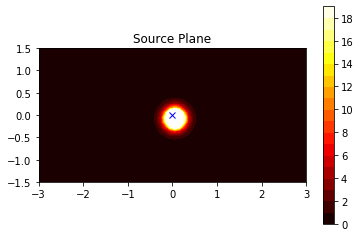

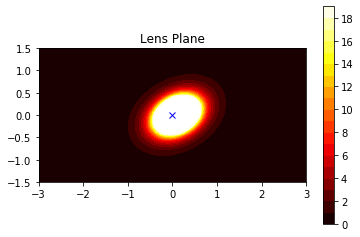

In [8]:
# import the LightModel class
from lenstronomy.LightModel.light_model import LightModel

# set up the list of light models to be used 

# this is saying that the source has a sersic light model
source_light_model_list = ['SERSIC']
#this feeds the source light model into LightModel, to create the lightModel_source object
lightModel_source = LightModel(light_model_list=source_light_model_list)

#this is saying that the lens has a sersic ellipse light model
lens_light_model_list = ['SERSIC_ELLIPSE']
#this feeds the lens light model into LightModel, to create the lightModel_lens object
lightModel_lens = LightModel(light_model_list=lens_light_model_list)

#this defines the keyword arguments of the light source, and centers it where the source is located from previous 
kwargs_light_source = [{'amp': 100, 'R_sersic': 0.1, 'n_sersic': 1.5, 'center_x': beta_ra, 'center_y': beta_dec}]

#this stuff is to do with handling the parameters which are fed into the lens light, though not sure how it works yet
import lenstronomy.Util.param_util as param_util
e1, e2 = param_util.phi_q2_ellipticity(phi=0.5, q=0.7)
kwargs_light_lens = [{'amp': 1000, 'R_sersic': 0.1, 'n_sersic': 2.5, 'e1': e1, 'e2': e2, 'center_x': 0.1, 'center_y': 0}]

# evaluate surface brightness at a specific position
flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)


## Point Source Module

The point source model list has two options:

'Source Position' allows one to enter the positions in source (beta) coordinates

'Image Position' allows one to enter the image coordinates. Note that, if there are multiple images, you enter an array of coordinates

In the arguments of PointSource, you enter the point_source_type_list, which is one of the above two options, as well as the lens model, and whether a fixed magnification list is used. 

If 'Source_Position' is used, then fixed_magnification_list must be True

If 'Lensed_Position' is used, then fixed magnification list must be False

Point Source can then be used to return the image and source positions and amplitudes

Also contains info at: https://lenstronomy.readthedocs.io/en/latest/lenstronomy.PointSource.html



In [9]:
# import the PointSource class #
from lenstronomy.PointSource.point_source import PointSource

# unlensed source positon #
point_source_model_list = ['SOURCE_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lensModel=lensModel, fixed_magnification_list=[True])
kwargs_ps = [{'ra_source': beta_ra, 'dec_source': beta_dec, 'source_amp': 1}]
# return image positions and amplitudes #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)

# lensed image positions (solution of the lens equation) #
point_source_model_list = ['LENSED_POSITION']
pointSource = PointSource(point_source_type_list=point_source_model_list, lensModel=lensModel, fixed_magnification_list=[False])
kwargs_ps = [{'ra_image': theta_ra, 'dec_image': theta_dec, 'point_amp': 1}]
# return image positions and amplitudes #
x_pos, y_pos = pointSource.image_position(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)
point_amp = pointSource.image_amplitude(kwargs_ps=kwargs_ps, kwargs_lens=kwargs_lens)

## Data module

This basically manages the coordinate frame and coordinate-to-pixel transformation necessary for image simulation. 

PSF handles the point spread function convolution

Also possible to manage data specific quantities like pixel values and noise properties that are required when fitting models to data to estimate the likelihood of the data given a model.

*note that what is called Data in the guide should actually be ImageData

In [10]:
# import the PixelGrid() class #
from lenstronomy.Data.pixel_grid import PixelGrid
deltaPix = 0.05  # size of pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
ra_at_xy_0, dec_at_xy_0 = -2.5, -2.5 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': 100, 'ny': 100,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)

# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates
# compute pixel value of a coordinate position #
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
# compute the coordinate value of a pixel position #
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

# import the PSF() class #
from lenstronomy.Data.psf import PSF
kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.1,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)
# return the pixel kernel corresponding to a point source # 
kernel = psf.kernel_point_source

## Image Simulation

Here, we combine LensModel, LightModel, PointSource and Data to model images.

LightModel can model both the lens light, which is unlensed, and the source light, which is lensed (test whether lens light can be lensed in multi-plane lensing). It says ImSim supports all the functionalities of those components, so I guess it would?



c:\users\daniel johnson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10


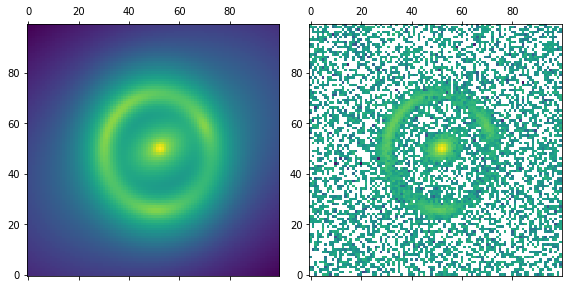

In [11]:
# import the ImageModel class #
from lenstronomy.ImSim.image_model import ImageModel
# define the numerics #
kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}
# initialize the Image model class by combining the modules we created above #
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=None, # in this example, we do not simulate point source.
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens, kwargs_ps=kwargs_ps)

# we can also add noise #
import lenstronomy.Util.image_util as image_util
exp_time = 100  # exposure time to quantify the Poisson noise level
background_rms = 0.1  # background rms value
poisson = image_util.add_poisson(image, exp_time=exp_time)
bkg = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + bkg + poisson

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False, sharey=False)
axes[0].matshow(np.log10(image), origin='lower')
axes[1].matshow(np.log10(image_noisy), origin='lower')
f.tight_layout()
plt.show()

## Linear Inversion

Parameters which correspond to an amplitude of surface brightness distribution (i.e. how intrinsically bright the object being viewed is, post lensing) are linearly related to the predicted flux values of pixels (i.e. the brighter the thing being viewed, the higher the flux received in a pixel). Because of this, it is possible to infer these parameters by a alinear minimization (linear inversion), via lenstronomy.

The linear parameters are those relating to amplitudes. In this example, there are the 4 point source amplitudes, and the amplitudes of the Sersic profiles of the lens and source.

Amplitude is "surface brightness/amplitude value at the half light radius"

In order to perform the linear inversion, noise properties of the data must be assumed or known

*note, previously (in the Data Module cell), we just had kwargs_pixel. Now, we can add ImageData information*

We create a data_class with the image itself, as well as info about the pixel to angle transformation, the exposure time, the background and the direction in which the image was taken. We then fit a lens model, source model, lens light model, point source class and the appropriate key word arguments to this image

Basically, the idea is to reduce the number of parameters which must be provided, by inferring amplitude parameters using this linear inversion.

In [12]:
from lenstronomy.Data.imaging_data import ImageData

# update the data with the noisy image and its noise properties #
kwargs_data = {'image_data': image_noisy,
               'background_rms': background_rms,
               'exposure_time': exp_time,
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

data_class = ImageData(**kwargs_data)

from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
image_linear_fit = ImageLinearFit(data_class=data_class, psf_class=psf, lens_model_class=lensModel,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=pointSource, 
                        kwargs_numerics=kwargs_numerics)

# we do not require the knowledge of the linear parameters #
del kwargs_light_source[0]['amp']

# apply the linear inversion to fit for the noisy image #
image_reconstructed, _, _, _ = image_linear_fit.image_linear_solve(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source, 
                              kwargs_lens_light=kwargs_light_lens, kwargs_ps=kwargs_ps)

-1.0172065137580553 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.0172065137580553


c:\users\daniel johnson\appdata\local\programs\python\python37\lib\site-packages\lenstronomy\Plots\model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


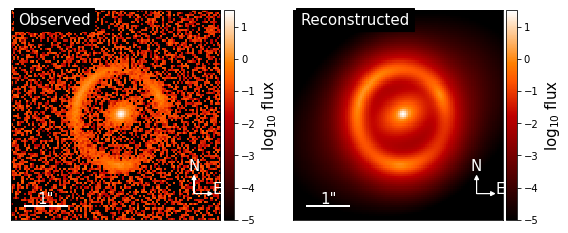

In [13]:
# illustrate fit #
from lenstronomy.Plots.model_plot import ModelPlot
kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_light_model_list,
               'lens_light_model_list': lens_light_model_list} #, 'point_source_model_list': point_source_model_list}
kwargs_params = {'kwargs_lens': kwargs_lens, 'kwargs_source': kwargs_light_source,
                 'kwargs_lens_light': kwargs_light_lens, 'kwargs_ps': kwargs_ps}
lensPlot = ModelPlot([[kwargs_data, kwargs_psf, kwargs_numerics]], kwargs_model, kwargs_params, arrow_size=0.02)

f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False, sharey=False)
lensPlot.data_plot(ax=axes[0])
lensPlot.model_plot(ax=axes[1])
f.tight_layout()
plt.show()

## Sampling Module

Basically, this is where the model is matched to the data

### Param class

This class manages all the model choices, and the parameters which are fed into these models. It is the interface of the *lenstronomy* convenctions of parameters, which are given as a list of keyword arguments, and the fitting conventions of CosmoHammer or emcee, which are given as a single array containing all the parameters. Note that CosmoHammer and emcee are algorithms for sampling from a probability distribution. The Param class also gives the option to

. keep certain parameters fixed
. handle linear parameters
. provide additional contraints on the modelling (e.g. fix source profile to point source position)

In [14]:
# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# set options for constraint parameters #
# Here we join the position of the lens light and mass center. 
# There are more options available in the Param() class.
kwargs_constraints = {'joint_lens_with_light': [[0, 0, ['center_x', 'center_y']]]}

# list fixed parameters #
kwargs_fixed_lens = [{'gamma': 2.}, {'ra_0': 0, 'dec_0': 0}, {}]
kwargs_fixed_source = [{}]
kwargs_fixed_lens_light = [{}]

# optional: list lower and upper bounds in parameter space, otherwise it will be using lenstronomy default values! #
# list lower bounds in parameter space #
kwargs_lower_lens = [{'theta_E': 0, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10., 'center_y': -10},
                     {'gamma1': -0.5, 'gamma2': -0.5}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = None

# list upper bounds in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10., 'center_y': 10},
                     {'gamma1': 0.5, 'gamma2': 0.5}]
kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = None

# make instance of parameter class with given model options, constraints and fixed parameters #
param = Param(kwargs_model, kwargs_fixed_lens, kwargs_fixed_source,
              kwargs_fixed_lens_light, kwargs_fixed_ps=None, 
              kwargs_lower_lens=kwargs_lower_lens, kwargs_lower_source=kwargs_lower_source,
              kwargs_lower_lens_light=kwargs_lower_lens_light, kwargs_lower_ps=kwargs_lower_ps,
              kwargs_upper_lens=kwargs_upper_lens, kwargs_upper_source=kwargs_upper_source,
              kwargs_upper_lens_light=kwargs_upper_lens_light, kwargs_upper_ps=kwargs_upper_ps,
              kwargs_lens_init=kwargs_lens, **kwargs_constraints)

# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

# parameter array for fitting routine #
param_array = param.kwargs2args(kwargs_lens, kwargs_light_source, kwargs_light_lens, kwargs_ps)

# recover keyword arguments list for lenstronomy from a parameter array of the fitting routine #
kwargs_out = param.args2kwargs(param_array)

# print settings #
param.print_setting()

The following model options are chosen:
Lens models: ['EPL', 'SHEAR']
Source models: ['SERSIC']
Lens light models: ['SERSIC_ELLIPSE']
Point source models: []
The following parameters are being fixed:
Lens: [{'gamma': 2.0, 'center_x': 0, 'center_y': 0}, {'ra_0': 0, 'dec_0': 0}, {}]
Source: [{'amp': 1}]
Lens light: [{'amp': 1}]
Point source: []
Joint parameters for different models
Joint lens with lens: []
Joint lens light with lens light: []
Joint source with source: []
Joint lens with light: [[0, 0, ['center_x', 'center_y']]]
Joint source with point source: []
Joint lens light with point source: []
Number of non-linear parameters being sampled:  15
Parameters being sampled:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
Number

### Likelihood Class

This manages the specific likelihood function, consisting of the imaging likelihood and potential other data and constraints. It performs the likelihood computation, combining the ImSim module with the Param module, and can evaluate imaging likelihoods, image position and time-delay likelihood with various options. (see documentation)

In [15]:
kwargs_likelihood = {'source_marg': False,
                    'check_matched_source_position': True,
                    'source_position_tolerance': 0.001,}
single_band = [[kwargs_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': single_band, 'multi_band_type': 'multi-linear'}

from lenstronomy.Sampling.likelihood import LikelihoodModule
likelihoodModule = LikelihoodModule(kwargs_data_joint, kwargs_model, param_class=param, **kwargs_likelihood)

logL = likelihoodModule.logL(args=param_array)

### Sampler Class

Performs the sampling of the likelihood.

In [16]:
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
kwargs_lens_init = [{'theta_E': 1.2, 'e1': 0, 'e2': 0, 'gamma': 2., 'center_x': 0., 'center_y': 0},
                    {'gamma1': 0, 'gamma2': 0}]
kwargs_source_init = [{'R_sersic': 0.03, 'n_sersic': 1., 'center_x': 0, 'center_y': 0}]
kwargs_lens_light_init = [{'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.3, 'e1': 0.5, 'e2': 0.5, 'gamma': .2, 'center_x': 0.1, 'center_y': 0.1},
                     {'gamma1': 0.05, 'gamma2': 0.05}]
kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1}]
kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.2, 'e2': 0.2, 'center_x': .1, 'center_y': 0.1}]

param_init = param.kwargs2args(kwargs_lens_init, kwargs_source_init, kwargs_lens_light_init, kwargs_ps=None)
param_sigma = param.kwargs2args(kwargs_lens_sigma, kwargs_source_sigma, kwargs_lens_light_sigma, kwargs_ps=None)

upper_start = np.array(param_init) + np.array(param_sigma)
lower_start = np.array(param_init) - np.array(param_sigma)

from lenstronomy.Sampling.sampler import Sampler
sampler = Sampler(likelihoodModule=likelihoodModule)

result, chain_properties = sampler.pso(n_particles=10, n_iterations=10, lower_start=lower_start, upper_start=upper_start)

kwargs_result = param.args2kwargs(result)

c:\users\daniel johnson\appdata\local\programs\python\python37\lib\site-packages\lenstronomy\LensModel\Profiles\epl.py:272: RuntimeWarning: invalid value encountered in true_divide
  R_omega = Z*hyp2f1(1, t/2, 2-t/2, -(1-q)/(1+q)*(Z/Z.conj()))
c:\users\daniel johnson\appdata\local\programs\python\python37\lib\site-packages\lenstronomy\LensModel\Profiles\epl.py:275: RuntimeWarning: divide by zero encountered in true_divide
  alpha = 2/(1+q)*(b/R)**t*R_omega
c:\users\daniel johnson\appdata\local\programs\python\python37\lib\site-packages\lenstronomy\LensModel\Profiles\epl.py:275: RuntimeWarning: invalid value encountered in multiply
  alpha = 2/(1+q)*(b/R)**t*R_omega


Computing the PSO ...
10
Max iteration reached! Stopping.
-2.8400089431201976 reduced X^2 of best position
-14175.904639584467 logL
9983 effective number of data points
[{'theta_E': 0.8780109286242345, 'gamma': 2.0, 'e1': -0.4559469679030584, 'e2': -0.25203476921009405, 'center_x': 0.08077164413577913, 'center_y': -0.010366250880210127}, {'gamma1': 0.026821093702458658, 'gamma2': 0.017432622707737135, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.07032031558416278, 'n_sersic': 0.9208385666206138, 'center_x': 0.12203116142752977, 'center_y': -0.016899836898187318}] source result
[{'amp': 1, 'R_sersic': 0.048519849282551465, 'n_sersic': 0.8060492362595445, 'e1': 0.12396471233010198, 'e2': -0.12483397361784351, 'center_x': 0.08077164413577913, 'center_y': -0.010366250880210127}] lens light result
[] point source result
{} special param result
1.0607264041900635 time used for  PSO


## Workflow Module

Manages the execution of non-linear fitter (in this case the PSO) and the parameter inference (the CosmoHammer emcee). The two main classes are Param and FittingSequence, which handle all the model choices of the user and mitigate them to the external modules and from the external modules back to *lenstronomy. 

### FittingSequence class

Allows a PSO and/or MCMC run. A sequence of fitting routines, applied one after the other, can be run, where the results of the previous routine are taken as the input of the next one. The user can optionally specify to keep one or multiple parameter classes (lens model, source model, lens light model and source light model) fixed during the fitting process or parameter inference. 

The user must specify:

. define input guess and uncertainties
. hard bounds on parameters
. number of particles and number of iterations being perormed by the PSO/MCMC
. enables MPI run through a set of fitting sequences

In [17]:
lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_fixed_lens, kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_fixed_source, kwargs_lower_source, kwargs_upper_source]
lens_light_params = [kwargs_light_lens, kwargs_lens_light_sigma, kwargs_fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}

band_list = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = []
multi_band_list.append(band_list)


from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=False)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1, 'n_particles': 100, 'n_iterations': 100, 'threadCount': 1}],
                       ['MCMC', {'n_burn': 200, 'n_run': 200, 'walkerRatio': 10, 'sigma_scale': .01, 'threadCount': 1}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.019819779181311 reduced X^2 of best position
-5090.4304277835145 logL
9983 effective number of data points
[{'theta_E': 1.0999032431138844, 'gamma': 2.0, 'e1': 0.1208477035515509, 'e2': 0.0876209119511715, 'center_x': 0.10153396349292797, 'center_y': 0.0009846377721455274}, {'gamma1': 0.0009552448292073185, 'gamma2': 0.021533030965566927, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.11629700161647993, 'n_sersic': 1.7006029429641167, 'center_x': 0.05671937588922693, 'center_y': -0.07970501527145811}] source result
[{'amp': 1, 'R_sersic': 0.09886070397688641, 'n_sersic': 2.590183664016121, 'e1': 0.09895257255629913, 'e2': 0.1651823081902495, 'center_x': 0.10153396349292797, 'center_y': 0.0009846377721455274}] lens light result
[] point source result
{} special param result
148.07613158226013 time used for  PSO


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [11:52<00:00,  1.78s/it]

Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  200
Sampling iterations (in current run): 400
714.2560381889343 time taken for MCMC sampling


### LensModelPlot class

Facilitates the plotting of models, comparison with data etc. Also meant to illustrate the post processing

-1.0159225031882853 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.0159225031882853


c:\users\daniel johnson\appdata\local\programs\python\python37\lib\site-packages\lenstronomy\Plots\model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
c:\users\daniel johnson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  # This is added back by InteractiveShellApp.init_path()


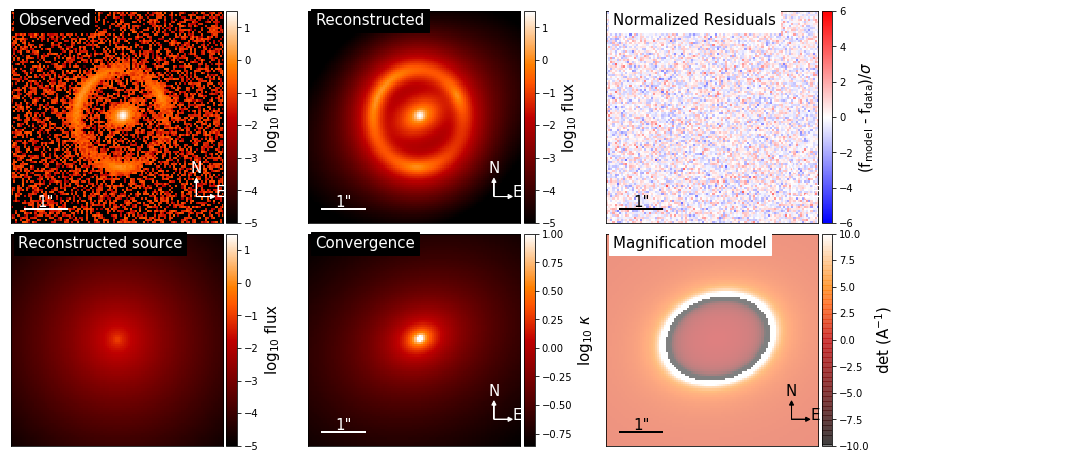

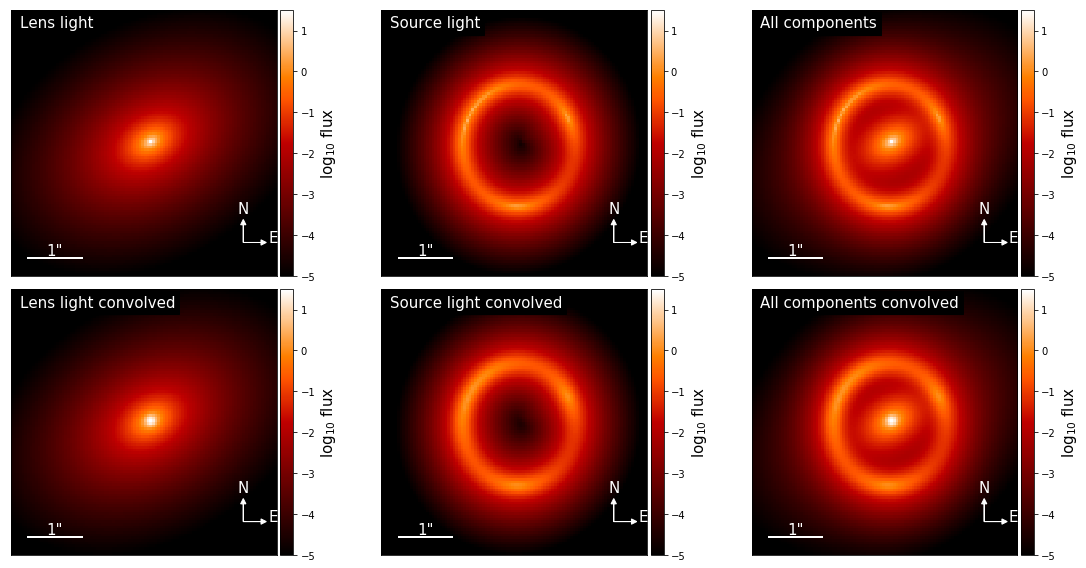

{'kwargs_lens': [{'theta_E': 1.09950220258763, 'gamma': 2.0, 'e1': 0.09152882906680256, 'e2': 0.09713095859403291, 'center_x': 0.10175961741730198, 'center_y': 0.00011141322776862513}, {'gamma1': -0.01295575308525566, 'gamma2': 0.02861750580694621, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 81.29230703289856, 'R_sersic': 0.10939528673747131, 'n_sersic': 1.7051019209538616, 'center_x': 0.0578728798160704, 'center_y': -0.07498327837368145}], 'kwargs_lens_light': [{'amp': 1012.3439347676505, 'R_sersic': 0.09913526812800144, 'n_sersic': 2.619092248431719, 'e1': 0.09293499557266835, 'e2': 0.15746008520693905, 'center_x': 0.10175961741730198, 'center_y': 0.00011141322776862513}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [18]:
modelPlot = ModelPlot([[kwargs_data, kwargs_psf, kwargs_numerics]], kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

number of non-linear parameters in the MCMC process:  15
parameters in order:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
number of evaluations in the MCMC process:  30000


c:\users\daniel johnson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':
c:\users\daniel johnson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app
c:\users\daniel johnson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


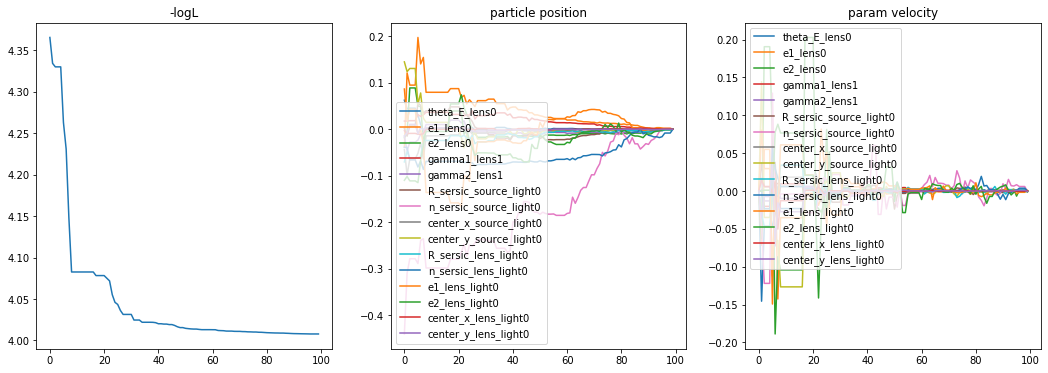

<Figure size 432x288 with 0 Axes>

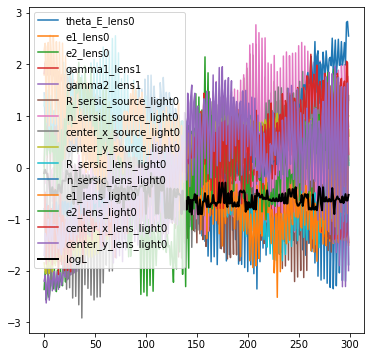

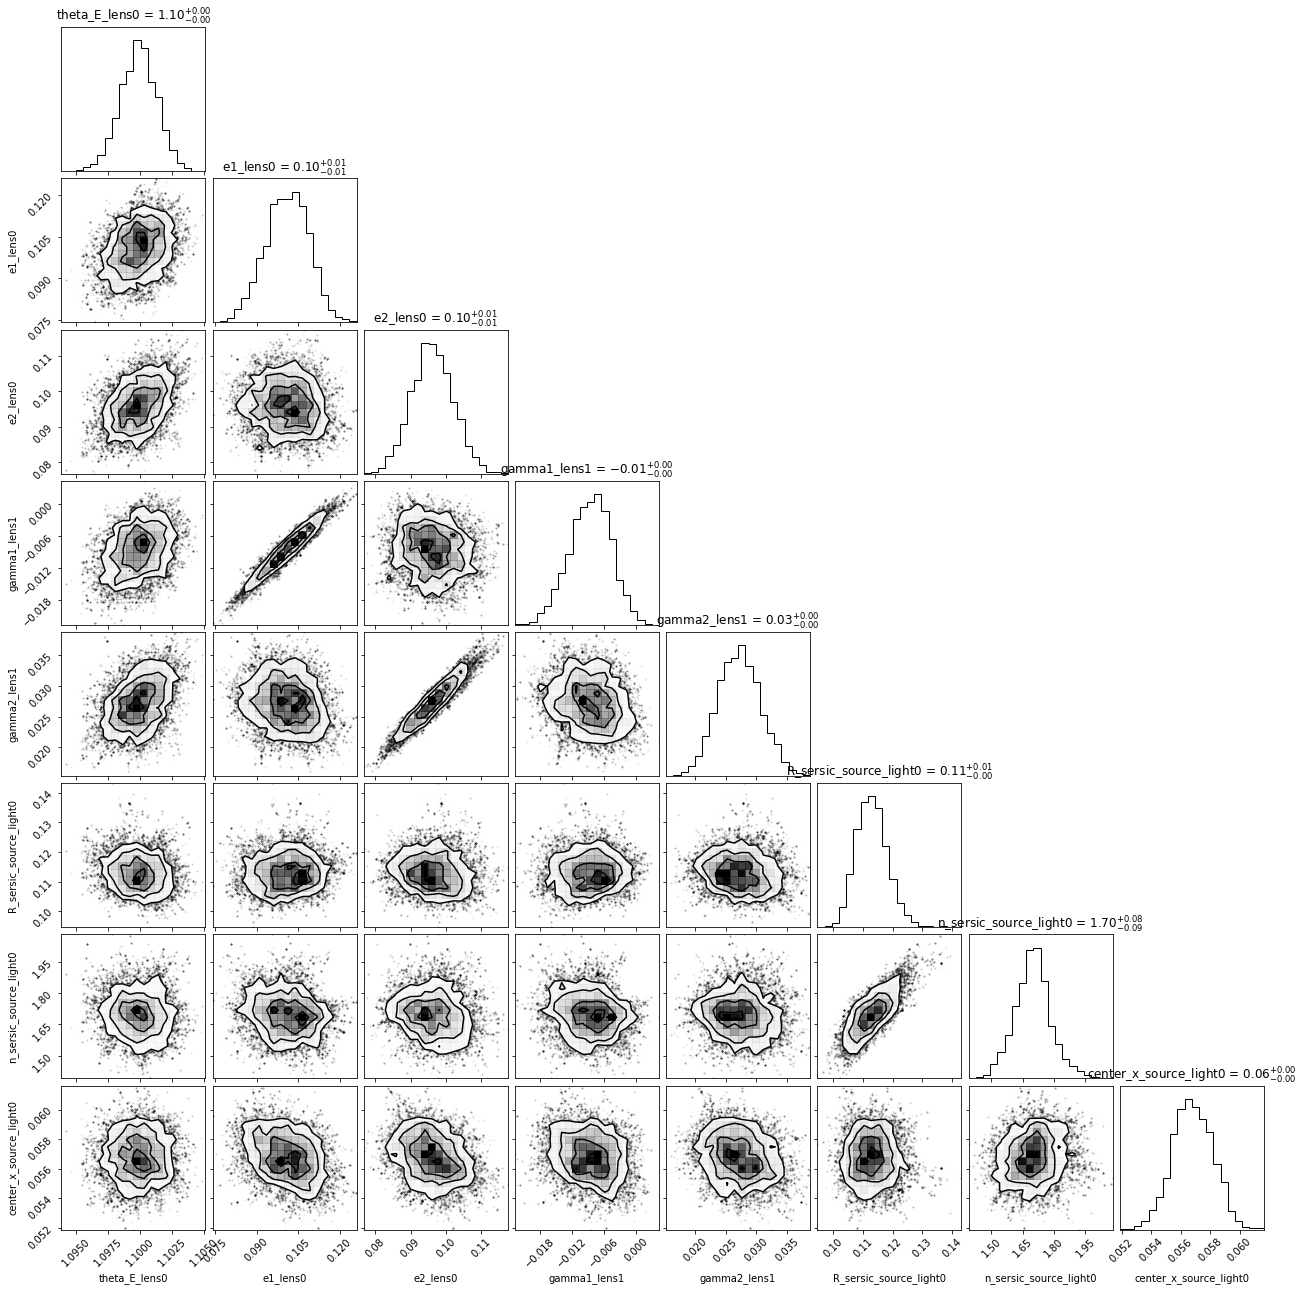

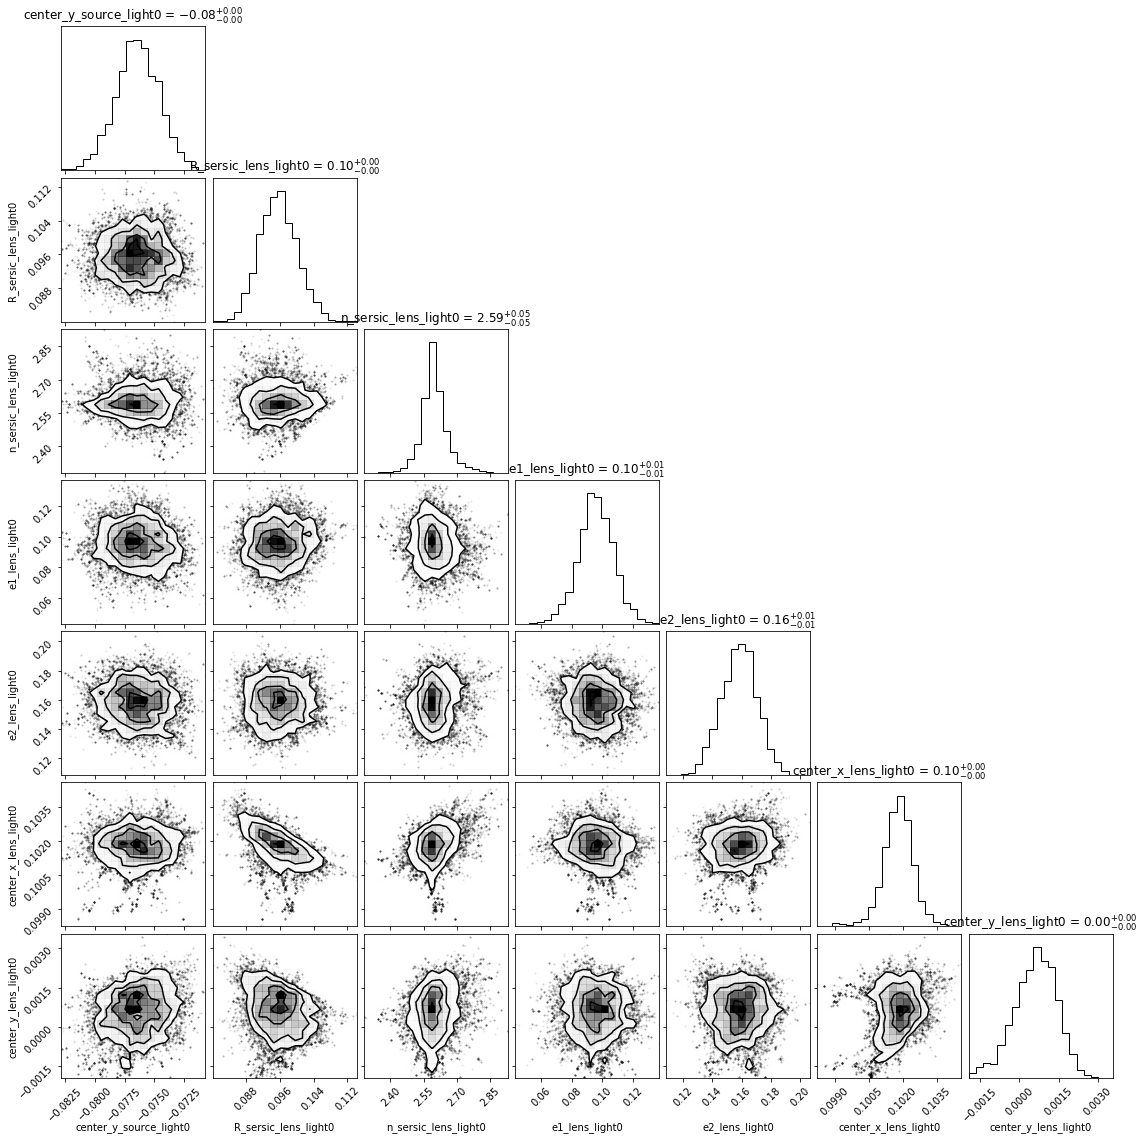

In [19]:
from lenstronomy.Plots import chain_plot

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]
print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])

import corner  # pip install corner  (if you have not installed it)
if not samples_mcmc == []:
        n, num_param = np.shape(samples_mcmc)
        plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)
        plot.show()
        plot = corner.corner(samples_mcmc[:,8:], labels=param_mcmc[8:], show_titles=True)
        plot.show()

# Lenstronomy



In [2]:
# Import of standard python libraries
import numpy as np
import os
import time
import corner
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from lenstronomy.LensModel.lens_model import LensModel

lens_model_list = ['SIS', 'LOS']
lens_model = LensModel(lens_model_list)

Adding LOS to the main lens.


Although you can't add two occurrences of LOS to the lens model, you can combine LOS and SHEAR


In [3]:
LensModel(['SIS', 'LOS', 'LOS'])

ValueError: You can only have one model for line-of-sight corrections.

In [4]:
LensModel(['SIS', 'SHEAR', 'LOS'])

Adding LOS to the main lens.


You can't do multi-plane lensing

In [5]:
lens_model_list = ['SIS', 'SIS', 'LOS']
z_s = 2
lens_redshift_list = [0.5, 1, 0]
LensModel(lens_model_list,
          lens_redshift_list=lens_redshift_list,
          z_source=z_s,
          multi_plane=True)

ValueError: LOS effects and multi-plane lensing are incompatible.

But you can have multiple lens models in the same plane

In [6]:
lens_model_list = ['SIS', 'SIS', 'LOS']
LensModel(lens_model_list)

Adding LOS to the main lens.


In [ ]:
kwargs_LOS = {
    'kappa_od': 0, 'kappa_os': 0, 'kappa_ds': 0,
    'omega_od': 0, 'omega_os': 0, 'omega_ds': 0,
    'gamma1_od': 0.05, 'gamma2_od': 0,
    'gamma1_os': 0, 'gamma2_os': 0.1,
    'gamma1_ds': -0.03, 'gamma2_ds': 0}

def T():
    tau_ds = (1+z)*D_od*D_os/D_ds
    return tau_ds*(0.5*alpha_eff(theta)*(1+gamma_LOS)*alpha_eff(theta)-psi_eff(theta))